In [1]:
s = "ten of the toys"
s = "There is a ghost in the room "
s = "Dole was defeated by Clinton"
#s = "the Chair's office"
show_depparse(s)

In [ ]:
s = "he ran to school."
show_depparse(s)

###### Pre-settings

In [1]:
import spacy
import neuralcoref
nlp = spacy.load("en")
# spacy POS list: https://github.com/explosion/spaCy/blob/master/spacy/glossary.py

In [2]:
from spacy import displacy # https://spacy.io/usage/visualizers
def show_depparse(text):
    doc = nlp(text)
    displacy.render(doc, style='dep',jupyter=True)
# example
#t = "Robin Kuo is walking away from the house. The house is very scary."
#t = "Jon Sena gave up finding his make up in the World Wild University."
t = "He is nice, tall and cool."
show_depparse(t)

In [3]:
### spacy examples
# doc = nlp(t)
# for token in doc:
#     print(token.text,"\t", token.dep_,"\t", token.head.text, token.head.pos_, token.lemma_,
#            [child for child in token.children])
#     print(token.text, token.head.text, token.dep_)

# for sent_idx, sent in enumerate(doc.sents):
#     print(sent, sent_idx)
#     for token in sent:
#         print(token.lemma_, token.head.lemma_, token.dep_)
#     print("=====")
#     ### NER
#     for ent in sent.ents:
#         print(ent.text, ent.label_, ent.lemma_)
#     print("=====")

#### start ann

In [4]:
def ann_sent_info(text):
    sent_list = []

    doc = nlp(text)
    for sent_idx, sent in enumerate(doc.sents):
        sent_info = {}
        sent_info["sent"] = sent
        sent_info["token"] = [] # info of each token
        tmp_idx_dict = dict()
        for tok_idx, tok in enumerate(sent):
            if tok.lemma_ == "-PRON-":
                lemma = tok.text.lower()
            else: 
                lemma = tok.lemma_
            s = {
                "word": tok.text,
                "pos": tok.pos_,
                "ner": None,
                "lemma": lemma,
                "sent_idx": sent_idx,
                "tok_idx": tok_idx,
            }
            sent_info["token"].append(s)
            if tok.lemma_ not in tmp_idx_dict:
                tmp_idx_dict[tok.lemma_] = [tok_idx]
            else:
                tmp_idx_dict[tok.lemma_].append(tok_idx)
        
        sent_info["dep"] = []   # info of the dependency between tokens
        for tok_idx, tok in enumerate(sent):
            if tok != tok.head: # tok==tok.head => no dep point to tok
                dep = {
                    "source": tmp_idx_dict[tok.head.lemma_][0],  # token head 
                    "target": tmp_idx_dict[tok.lemma_][0],  # token
                    "dep": tok.dep_,
                    "sent_idx": sent_idx
                }
                if len(tmp_idx_dict[tok.lemma_]) > 1:
                    tmp_idx_dict[tok.lemma_].pop(0) # del first idx in the list
                sent_info["dep"].append(dep)
        sent_list.append(sent_info)
    return sent_list

In [5]:
t = "Taiwan people need Taiwan government."
#t = "Robin Kuo is walking away from the house. The house is very scary."
t = "They are cool."
ann_sent_info(t)

[{'sent': They are cool.,
  'token': [{'word': 'They',
    'pos': 'PRON',
    'ner': None,
    'lemma': 'they',
    'sent_idx': 0,
    'tok_idx': 0},
   {'word': 'are',
    'pos': 'VERB',
    'ner': None,
    'lemma': 'be',
    'sent_idx': 0,
    'tok_idx': 1},
   {'word': 'cool',
    'pos': 'ADJ',
    'ner': None,
    'lemma': 'cool',
    'sent_idx': 0,
    'tok_idx': 2},
   {'word': '.',
    'pos': 'PUNCT',
    'ner': None,
    'lemma': '.',
    'sent_idx': 0,
    'tok_idx': 3}],
  'dep': [{'source': 1, 'target': 0, 'dep': 'nsubj', 'sent_idx': 0},
   {'source': 1, 'target': 2, 'dep': 'acomp', 'sent_idx': 0},
   {'source': 1, 'target': 3, 'dep': 'punct', 'sent_idx': 0}]}]

In [6]:
### create all nodes
def create_all_nodes(sent_list):
    node_dict = {}  # save the nodes
    node_index = {} # table convert tok_sent_idx to node_key

    for sent_idx, sent_info in enumerate(sent_list):
        node_index[sent_idx] = {}
        compound_list = []
        for tok in sent_info['token']:
            node_key = tok['lemma'] + "=" + tok['pos']
            node_index[sent_idx][tok['tok_idx']] = node_key
            
            # save node_key in node_dict
            if node_key not in node_dict:
                node_dict[node_key] = [tok]
            else:
                node_dict[node_key].append(tok)
                
        # 從dependency 找 compound
        node_dict, node_index = process_compound_dep(sent_info, node_dict, node_index)
    return node_dict, node_index

def process_compound_dep(sent_info, node_dict, node_index):
    for dep in sent_info['dep']:
        if "compound" in dep['dep']:
            source_node_key = node_index[dep['sent_idx']][dep['source']]
            if len(node_dict[source_node_key]) > 1: # node already merged (by ner
                continue
            else:
                merge_two_node(node_dict, node_index, sent_info['token'], dep)
    return node_dict, node_index

def merge_two_node(node_dict, node_index, tok, dep):
    source_idx = dep['source']
    target_idx = dep['target']
    sent_idx = dep['sent_idx']

    tok_original_pos = tok[source_idx]['pos']
    node_key = tok[target_idx]['lemma'] + '_' + tok[source_idx]['lemma'] + "=" + tok_original_pos

#     print("==============")
#     print(node_key)
#     print(node_index[sent_idx][source_idx])
#     print(node_index[sent_idx][target_idx])
#     print("==============")
    
    remove_before_merge_node(node_dict, node_index[sent_idx][source_idx], sent_idx, source_idx)
    remove_before_merge_node(node_dict, node_index[sent_idx][target_idx], sent_idx, target_idx)
    node_index[sent_idx][source_idx] = node_key
    node_index[sent_idx][target_idx] = node_key

    if node_key not in node_dict:
        node_dict[node_key] = [tok[source_idx], tok[target_idx]]
    else:
        node_dict[node_key].extend([tok[source_idx], tok[target_idx]])
#    return node_dict, node_index    

def remove_before_merge_node(node_dict, node_key, sent_idx, tok_idx):
    if len(node_dict[node_key]) > 1:
        for node_idx, node in enumerate(node_dict[node_key]):
            if node['sent_idx'] == sent_idx and node['tok_idx'] == tok_idx:
                del node_dict[node_key][node_idx]
                break
    else:
        node_dict.pop(node_key)

# example
# text = "Taiwan engineers lives in Taiwan house."
#text = "Taiwan is where Taiwan engineers lives."
# text = "Robin Kuo took off his shoe. Robin give up. Kevin also will not give up."
text = "He is cool, nice and tall"
sent_list = ann_sent_info(text)
node_dict, node_index = create_all_nodes(sent_list)
print(node_index)
print(node_dict.keys())

{0: {0: 'he=PRON', 1: 'be=VERB', 2: 'cool=ADJ', 3: ',=PUNCT', 4: 'nice=ADJ', 5: 'and=CCONJ', 6: 'tall=ADJ'}}
dict_keys(['he=PRON', 'be=VERB', 'cool=ADJ', ',=PUNCT', 'nice=ADJ', 'and=CCONJ', 'tall=ADJ'])


In [30]:
def create_relation_between_node(sent_list, node_dict, node_index, all_dep=False):
    dep_list = []
    for sent_idx, sent_info in enumerate(sent_list):
        if all_dep:
            for dep in sent_info["dep"]:
                source = node_index[sent_idx][ dep['source'] ]
                target = node_index[sent_idx][ dep['target'] ]
                dep_list.append((source, target, dep['dep']))
        else:
            for dep in sent_info["dep"]:
                source = node_index[sent_idx][ dep['source'] ]
                target = node_index[sent_idx][ dep['target'] ]
                if dep['dep'] == 'nsubj':
                    dep_list.append((source, target, dep['dep']))
                elif dep['dep'] in ['obl','obj', 'lobj', 'dobj', 'iobj']:
                    dep_list.append((source, target, dep['dep']))
                elif dep['dep'] in ['xcomp', 'ccomp']:
                    dep_list.append((source, target, dep['dep']))
                elif dep['dep'] in ['acomp']:
                    dep_list.append((source, target, dep['dep']))
                elif dep['dep'] in ['advmod']: # reverse: big->very => very->big
                     dep_list.append((target, source, dep['dep']))
#                    dep_list.append((source, target, dep['dep']))
                elif dep['dep'] == 'nmod':
                    dep_list.append((source, target, dep['dep']))
                elif dep['dep'] in ["conj"]:
                    copy_other_dep(dep_list, source, target)

#                     for past_dep in dep_list:
#                         past_source = past_dep[0]
#                         past_target = past_dep[1]
#                         past_dep = past_dep[2]
#                         if source == past_source:  # text = "I am cool and tall."
#                             dep_list.append((target, past_target, past_dep))
#                             break
#                         elif source == past_target: # text = "I eat egg and pie."
#                             dep_list.append((past_source, target, past_dep))
#                             break
#                     # before: ('cool=JJ', 'I=NN', 'nsubj'), ('cool=JJ', 'tall=JJ', 'conj')
#                     # after:  ('cool=JJ', 'I=NN', 'nsubj'), ('tall=JJ', 'I=NN', 'nsubj')
    return dep_list

def copy_other_dep(dep_list, source, target):
    # example
    # before: ('cool=JJ', 'I=NN', 'nsubj'), ('cool=JJ', 'tall=JJ', 'conj')
    # after:  ('cool=JJ', 'I=NN', 'nsubj'), ('tall=JJ', 'I=NN', 'nsubj')
    for past_dep in dep_list:
        past_source = past_dep[0]
        past_target = past_dep[1]
        past_dep = past_dep[2]
        if source == past_source:  # "I am cool and tall." => cool->I , tall->I
            dep_list.append((target, past_target, past_dep))
        elif source == past_target: # "I eat egg and pie." => eat->egg , eat->pie
            dep_list.append((past_source, target, past_dep))


# example
# text = "I drink water, milk and juice."
# text = "Robin took off his shoe and ran into the water. After he returned the shoe was gone."
# text = "Robin Kuo took off his shoe. Robin give up. Kevin also will not give up."
text = "He is cool, nice and tall"
#text = "Jon Sena gave up his dinner table in the World Wild University. He later give up another dinner table here."
sent_list = ann_sent_info(text)
node_dict, node_index = create_all_nodes(sent_list)
print( [i for i in node_dict] )
dep_list = create_relation_between_node(sent_list, node_dict, node_index, all_dep=False)
dep_list

['he=PRON', 'be=VERB', 'cool=ADJ', ',=PUNCT', 'nice=ADJ', 'and=CCONJ', 'tall=ADJ']


[('be=VERB', 'he=PRON', 'nsubj'),
 ('be=VERB', 'cool=ADJ', 'acomp'),
 ('be=VERB', 'nice=ADJ', 'acomp'),
 ('be=VERB', 'tall=ADJ', 'acomp')]

In [8]:
import networkx as nx 
import matplotlib.pyplot as plt 

def draw_undirect_graph(dep_list):
    G = nx.MultiGraph() 
    relations = dep_list
    
    for i in relations: 
        G.add_edge(i[0], i[1], relation = i[2]) 

    plt.figure(figsize =(9, 9)) 
    nx.draw_networkx(G, with_label = True, node_color="yellow") 

    # getting various graph properties 
    print("Total number of nodes: ", int(G.number_of_nodes())) 
    print("Total number of edges: ", int(G.number_of_edges())) 
    print("List of all nodes: ", list(G.nodes())) 
    print("List of all edges: ", list(G.edges(data = True))) 
    print("Degree for all nodes: ", dict(G.degree())) 
    return G

def draw_direct_graph(dep_list):
    G = nx.DiGraph() 
    
    nodes_list = []
    for node in dep_list:
        nodes_list.append( (node[0], node[1]) )
    #nodes_list = [(1,1),(2,2),(3,2)]
    #nodes_list = [('2=end', '1=The'), ('6=command', '4=the'),('2=end', '6=command'),('2=end', '7=.'),('6=command', '3=of'),('6=command', '5=CPU')]
    G.add_edges_from(nodes_list)

    plt.figure(figsize =(9, 9)) 
    nx.draw_networkx(G, with_label = True, node_color ='yellow') 

    # getting different graph attributes 
    print("Total number of nodes: ", int(G.number_of_nodes())) 
    print("Total number of edges: ", int(G.number_of_edges())) 
    print("List of all nodes: ", list(G.nodes())) 
    print("List of all edges: ", list(G.edges())) 
    print("In-degree for all nodes: ", dict(G.in_degree())) 
    print("Out degree for all nodes: ", dict(G.out_degree)) 
    print("Total number of self-loops: ", int(G.number_of_selfloops())) 

def text_to_graph(text, direct_graph=False):
    sent_list = ann_sent_info(text)
    node_dict, node_index = create_all_nodes(sent_list)
    dep_list = create_relation_between_node(sent_list, node_dict, node_index)
    if direct_graph is True:
        draw_direct_graph(dep_list)
    else:
        draw_undirect_graph(dep_list)
    
# text = "I give the toy to her."
# text = "Robin took off his shoe and ran into the water. After he returned the shoe was gone."
# text = "Jon Sena gave up his dinner table in the World Wild University. He later gave up his bag."
# text = "Robin Kuo gave the toy to the child. Robin recive my toy."
# text = "An open compound word is created in cases when the modifying adjective is used with its noun to create a new noun. This isn’t quite the same as a noun with a modifying adjective. We just use a space between the adjective and the noun, so sometimes it can be hard to identify as a compound; however, if the two words are commonly used together, it’s considered to be a compound word."
# text = "She play piano and flute."
# direct_graph = True
# text_to_graph(text, direct_graph)

/Users/dragonfly/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/dragonfly/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


{'scary=ADJ': 2,
 'walk=VERB': 1,
 'Robin_Kuo=PROPN': 1,
 'house=NOUN': 1,
 'away=ADV': 0,
 'be=VERB': 0,
 'very=ADV': 0}

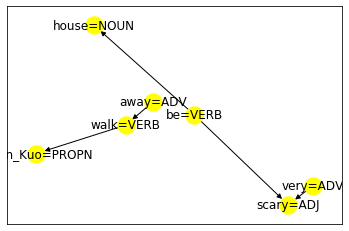

In [9]:
def get_keyphrase_weight(text, direct=True, in_edge=True, show_graph=False,all_dep=False, div_wcnt=False):
    
    sent_list = ann_sent_info(text)
    node_dict, node_index = create_all_nodes(sent_list)
    dep_list = create_relation_between_node(sent_list, node_dict, node_index, all_dep)

    if direct:
        G = nx.DiGraph()
    else:
        G = nx.MultiGraph() 
    for i in dep_list: # [('cool=JJ', 'he=NN', 'nsubj')]
        G.add_edge(i[0], i[1], relation=i[2]) 
    if show_graph:
        nx.draw_networkx(G, with_label = True, node_color="yellow")
    
    # ======= calculate weight ======= 
    # count how many edge attach to each node
    node_edge_cnt_dict = dict()
    for node in G.nodes:
        if direct==True and in_edge==True:
            node_edge_cnt_dict[node] = len(G.in_edges(node))
        else: # defeault out_edge
            node_edge_cnt_dict[node] = len(G.edges(node))

    # count how many times a word had appear
    node_word_cnt_dict = dict()
    for node in node_dict:
        node_word_cnt_dict[node] = len(node_dict[node])

    weight_node_dict = dict()
    for node in node_edge_cnt_dict.keys():
        if div_wcnt:
            weight_node_dict[node] = node_edge_cnt_dict[node] /node_word_cnt_dict[node]
        else:
            weight_node_dict[node] = node_edge_cnt_dict[node]
        #print(node , node_edge_cnt_dict[node] , "/", node_word_cnt_dict[node], "=", weight_node_dict[node])
    sorted_weight_node_dict = dict(sorted(weight_node_dict.items(), key=lambda k: k[1], reverse=True))
    return sorted_weight_node_dict

### example
#get_keyphrase_weight(new)
tex = "Robin Kuo is walking away from the house. The house is very scary."
get_keyphrase_weight(tex, direct=True, in_edge=True, show_graph=True, all_dep=False, div_wcnt=False)

##### find a way to evaluate

In [10]:
# https://www.taipeitimes.com/News/taiwan/archives/2021/04/19/2003755957
news1 = {
    "title": "Typhoon Surigae might bring rain, CWB says",
    "content": '''Typhoon Surigae is to bring rain to the nation’s east coast and mountainous areas in central and southern Taiwan from Wednesday to Friday, the Central Weather Bureau (CWB) said yesterday.
As of 2pm yesterday, the typhoon’s center was 1,170km southeast of Oluanpi (鵝鑾鼻), Taiwan’s southernmost tip. The radius of the storm was 280km, and it was moving northwest at 9kph, with a maximum wind speed of 198kph.
The bureau forecasts that the storm would switch to a northerly direction when approaching the east coast of Luzon Island in the Philippines on Wednesday, CWB forecaster Lin Ding-yi (林定宜) said, adding that Surigae would then move northeast along the Bashi Channel.
Chances of temporary showers would be high in Yilan, Hualien and Taitung counties, as well as in the mountainous areas of central and southern Taiwan, he said.
Surigae was to maintain its strength yesterday and today, Lin said, adding that similarly strong typhoons in April occurred in 1997, 2003 and 2015.
Typhoons usually occur from July to September, the bureau said.
Residents on the northern, eastern and southern coasts as well as those in Penghu and Kinmen counties should be prepared for swells, Lin said.
Peng Chi-ming (彭啟明), chief executive of WeatherRisk Explore Inc, yesterday wrote on Facebook that Surigae was at the peak of its strength, with lightning frequently occurring at its eye and convection at its circumfluence.
If it made landfall at this strength, it might cause a major disaster, he said.
However, it was a good sign that convective heat transfer in mountainous areas began to occur yesterday afternoon, Peng said.
“Convective heat transfer usually occurs on the west coast in April, but this year, it did not occur until yesterday,” he said.
Thermal instability in the mountains of southern Taiwan were influenced by the typhoon, he added.
CWB Director-General Cheng Ming-dean (鄭明典) said that Surigae has a double eyewall, which is generally a feature of strong typhoons, indicating that the storm might grow further before reaching Luzon.
However, Surigae would gradually weaken once it is moving away from Luzon, Cheng said, citing conditions unfavorable for the typhoon.
WeatherRisk analyst Wu Sheng-yu (吳聖宇) wrote on Facebook that Surigae would likely remain east of the Philippines for at least three to four days, and then accelerate its northward motion.
“When the westerly trough abates, Surigae could also bring rain from southeast China. This might be the best opportunity we have for rain since the beginning of this month. If rain does not occur this time, we might have to wait for next month,” Wu said.
Meanwhile, poor air quality was early yesterday recorded in the outlying island counties of Kinmen and Penghu, and parts of western Taiwan due to pollutants from China and stagnant winds, the Environmental Protection Administration said.
At 9am, 20 air monitoring stations in areas north of Hsinchu County and in Penghu and Kinmen detected generally unhealthy air quality at the “red alert” level, the agency said.
'''}

In [47]:
# find title keyword with spacy
topk_keyword = 20

def cal_overlap_score(topk_keyword, news):
    sent_list = ann_sent_info(news["title"])
    node_dict, _ = create_all_nodes(sent_list)
    title_word_list = list(node_dict.keys())
    #print("title_words:", title_word_list)

    keyword_dict = get_keyphrase_weight(news['content'], direct=True, in_edge=True, show_graph=False, all_dep=False)
    for idx, kw in enumerate(keyword_dict):
        keyword_list.append(kw)
        if idx > topk_keyword:
            break
    print("===== overlap keywords: =====")
    cnt_overlap = 0
    for k in title_word_list:
        if k in keyword_list:
            cnt_overlap += 1
            print(k, keyword_dict[k])
    print("=============================")
    print("final_score: {:.2f}".format( cnt_overlap / len(title_word_list)) )
# example
topk_keyword = 20
cal_overlap_score(topk_keyword, news1)

===== overlap keywords: =====
bring=VERB 4
rain=NOUN 2
Typhoon_Surigae=PROPN 3
final_score: 0.43


In [44]:
# find overlap_score with same keyword in title (lowerm lemma remove_stopword)

def cal_overlap_score(topk_keyword, news):
    # get stopwords
    stoppath = "./RAKE/SmartStoplist.txt"
    with open (stoppath, 'r') as f:
        stopw = f.read().split("\n")

    # preprocess title (lower, lemma, stopword)
    title_list = [str(title_word.lemma_).lower() for title_word in nlp(news["title"]) if str(title_word) not in stopw]

    # save topk=20 keywords
    keyword_list = []
    keyword_dict = get_keyphrase_weight(news['content'], direct=True, in_edge=True, show_graph=False, all_dep=False)
    for idx, kw in enumerate(keyword_dict):
        keyword_list.append(kw.split("=")[0].lower())
        if idx > topk_keyword:
            break

    # find overlap words
    overlap_words = []
    for title_word in title_list:
        if title_word in keyword_list:
            overlap_words.append(title_word)
    print("overlap_words: ", overlap_words)
    print("overlap_score: ", len(overlap_words) / len(title_list))

# example
topk_keyword = 20
cal_overlap_score(topk_keyword, news1)

overlap_words:  ['surigae', 'bring', 'rain']
overlap_score:  0.5


### Rake

In [22]:
from RAKE.rake import Rake

# find title keyword with Rake
stoppath = "./RAKE/SmartStoplist.txt"
r = Rake(stoppath)
title_word_list = [s[0] for s in r.run(news1['title'])]
title_word_list

['typhoon surigae', 'bring rain', 'cwb']

### neuralcoref

In [ ]:
import spacy
nlp = spacy.load('en')

# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp)

# You're done. You can now use NeuralCoref as you usually manipulate a SpaCy document annotations.
text = "Angela lives in Boston. She is quite happy in that city.'"
doc2 = nlp(text)
for ent in doc2.ents:
    print(ent, ent._.coref_cluster)

print('=====')
text = '''On Wednesday last week, the two pilots and another crew member had flown on the same plane to the US, quarantined at a hotel during a layover and returned to Taiwan on Friday, Chuang said. The CECC had eased the quarantine rules for flight crew members on Wednesday last week, so they needed to quarantine at home for only three days after their return and took a mandatory polymerase chain reaction (PCR) test on the third day, he said. The PCR test results returned positive for the two pilots, but negative for the crew member, who is now isolating at home, he said. '''
doc = nlp(text)
print(doc._.has_coref)
print(doc._.coref_clusters)

In [ ]:
# https://www.taipeitimes.com/News/front/archives/2021/04/21/2003756069
news2 = {"title": "Two Taiwanese airline pilots test positive: CECC"
"content":'''
Two Taiwanese pilots have tested positive for COVID-19, while 3,802 people have made appointments for out-of-pocket vaccinations this week, the Central Epidemic Command Center (CECC) said yesterday.
The two men, in their 50s and 60s, who fly cargo planes for a local airline, tested positive on Monday evening, said Centers for Disease Control (CDC) Deputy Director-General Chuang Jen-hsiang (莊人祥), who is the CECC’s spokesman.
The first man — case No. 1,078 — had flown a short-haul flight, departing and returning to Taiwan on Monday last week, and developed an itchy throat on Sunday, he said.
The other man — case No. 1,079 — had flown long-haul flights to India and Luxembourg between April 10 and Monday last week, he added.
On Wednesday last week, the two pilots and another crew member had flown on the same plane to the US, quarantined at a hotel during a layover and returned to Taiwan on Friday, Chuang said.
The CECC had eased the quarantine rules for flight crew members on Wednesday last week, so they needed to quarantine at home for only three days after their return and took a mandatory polymerase chain reaction (PCR) test on the third day, he said.
The PCR test results returned positive for the two pilots, but negative for the crew member, who is now isolating at home, he said.
Authorities are investigating the source of infection to determine whether they were infected abroad or on the plane, he added.
Reporting on the progress of vaccination in the nation, Chuang said that as of Monday, 33,404 people had received their first shot of the AstraZeneca vaccine.
Four adverse vaccine events were reported on Monday. One involved a man in his 60s who experienced respiratory symptoms 16 days after vaccination, and was diagnosed with vasculitis and interstitial pneumonia.
The man is being treated in an intensive care unit, Chuang said.
“The symptoms are unlike the adverse events reported in other countries after AstraZeneca vaccinations, which involved blood clots,” he said, adding that the case would be discussed at a specialist meeting today.
As of Monday afternoon, 3,802 people had booked appointments for self-pay vaccinations for this week, Chuang said.
Thirty-one designated hospitals started accepting appointments for self-pay vaccines on Monday, with inoculations to start today.
Chuang said that 1,407 people made appointments for today at 23 hospitals; 1,214 people made appointments for tomorrow at 23 hospitals; 963 people made appointments for Friday at 20 hospitals, and 218 people made appointments for Saturday at three hospitals.
He also clarified a remark he made on Monday, saying that the 10,000 vaccine doses set aside for self-pay jabs would be offered as the first shot to 10,000 people, rather than the first and second shots for 5,000 people.
More doses might be released if there is sufficient supply, he said.
'''}